In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm, ttest_ind, pearsonr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm


import env
import acquire
import prep
import split_scale
import features
import model

 
Deliverables:

1. A report (in for the form of a presentaion, both verbal and through slide)

Summarize your findings about the drivers of the Tax Value Count.
This will come from the analysis you do during the exploration phase of the pipeline.
In the report you will have charts that visually tell the story of what is driving the errors.

2. A github repository containing the jupyter notebook that walks through the pipeline along with the .py files necessary to reproduce your model.




Zillow Data Science Team Project Directive: 
Find qualities of properties that strongly influence the value of a home. Create a model that could be used to begin to predict a value of a home before an assesment is submitted. 
The data science team wants your model to have 95% a confidence interval. 

Which independent variables do you think influence the value of a home?

Hypothesis:

Variables that can influence the value of home are square feet,  and room count(bedroom, and bath). 
These two variables can have an influence no matter where the property located.

The more square feet of a property the more the value of the home will rise.
The higher the room count the cost will increase.
The total square footage of the property will be a stronger influence than room count

When you start to get into specific locations other factors can influence the value of a home such as zip code, school district, distance to destinations (work, home, restaurants, grocery).
Also home amenities will influence the value of a property, such as backyards with pools, garage size, hoa.
The age of home would also have influence.

To begin our modeling we will look at the features of squarefootage and room count to see how these will influence the target variable - value of the property. Further exploration of other property, and location specific features can be explored after this first phase is built.


***ACQUIRE***

Goal: Gather and describe data from zillow dataset that creates a dataframe with:
    Index : 
        parcelid,fips 
    Features:
        calculatedfinishedsquarefeet
        bathroomcnt
        bedroomcnt
        lotsizesquarefeet

Include head of the dataset, datatypes, summary stats, shape of the dataframe.



In [2]:
# get url for zillow database using your env file. Your env file should include variables that are assigned to your username, password, and host for mysql.

url = acquire.get_db_url('zillow')


In [3]:
# Create dataframe for your features and target variable using your query, and url variable.
# The features I was interested in exploring were bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, and lotsizesquarefeet. The target variable I want to predict is taxvaluedollarcnt

query = """ SELECT parcelid,
                   fips,
                   bathroomcnt, 
                   bedroomcnt, 
                   calculatedfinishedsquarefeet, 
                   lotsizesquarefeet,
                   taxvaluedollarcnt
            FROM properties_2017
            JOIN predictions_2017 using(parcelid)
            WHERE (propertylandusetypeid = 261) and (transactiondate BETWEEN '2017-05-01' and '2017-06-30') """
# From the acuire.py create your dataframe with get_data_from_mysql(query,db)

df = acquire.get_data_from_mysql(query,'zillow')


In [4]:
# Head of dataframe

df.head()


,parcelid,fips,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,taxvaluedollarcnt
0,11289917,6037.0,2.0,3.0,1458.0,8284.0,136104.0
1,11705026,6037.0,1.0,2.0,1421.0,6707.0,35606.0
2,14269464,6059.0,3.0,4.0,2541.0,4975.0,880456.0
3,11389003,6037.0,2.0,3.0,1650.0,7300.0,614000.0
4,11967869,6037.0,1.0,2.0,693.0,2908.0,274237.0


In [5]:
# data types of dataframe:

df.dtypes


parcelid                          int64
fips                            float64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
lotsizesquarefeet               float64
taxvaluedollarcnt               float64
dtype: object

All of our data types are floats or integers which are types that we can measure and quatify. There is not a need at this point to convert the features to another data type.


In [6]:
# inital summary stats:

initial_df = df.describe()
initial_max = df.max()
initial_min = df.min()


In [7]:
initial_df


,parcelid,fips,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,taxvaluedollarcnt
count,1.503600e+04,15036.000000,15036.000000,15036.000000,15012.000000,1.493200e+04,1.503600e+04
mean,1.303819e+07,6049.395318,2.322426,3.307595,1942.043165,1.062587e+04,5.434477e+05
std,3.927138e+06,21.237001,1.025202,0.951095,1001.672378,3.028759e+04,7.354153e+05
min,1.071210e+07,6037.000000,0.000000,0.000000,300.000000,5.940000e+02,1.050400e+04
25%,1.150329e+07,6037.000000,2.000000,3.000000,1274.750000,5.597000e+03,1.986335e+05
50%,1.258458e+07,6037.000000,2.000000,3.000000,1679.000000,6.876500e+03,3.851740e+05
75%,1.414342e+07,6059.000000,3.000000,4.000000,2346.000000,8.888000e+03,6.452412e+05
max,1.676878e+08,6111.000000,11.000000,12.000000,15450.000000,1.323788e+06,2.385837e+07


In [8]:
initial_max


parcelid                        167687839.0
fips                                 6111.0
bathroomcnt                            11.0
bedroomcnt                             12.0
calculatedfinishedsquarefeet        15450.0
lotsizesquarefeet                 1323788.0
taxvaluedollarcnt                23858374.0
dtype: float64

In [9]:
initial_min


parcelid                        10712101.0
fips                                6037.0
bathroomcnt                            0.0
bedroomcnt                             0.0
calculatedfinishedsquarefeet         300.0
lotsizesquarefeet                    594.0
taxvaluedollarcnt                  10504.0
dtype: float64

In [10]:
# dataframe columns:

df.columns


Index(['parcelid', 'fips', 'bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'lotsizesquarefeet',
       'taxvaluedollarcnt'],
      dtype='object')

In [11]:
# shape of dataframe:

df.shape


(15036, 7)

*PREP*

Goal: 
    Create a dataset that is ready to be analyzed. 
    Datatypes are appropriate, null values, and integrity issues have been addressed.

In [12]:
# Find amount of nulls in dataframe:

df.isnull().sum()


parcelid                          0
fips                              0
bathroomcnt                       0
bedroomcnt                        0
calculatedfinishedsquarefeet     24
lotsizesquarefeet               104
taxvaluedollarcnt                 0
dtype: int64

In [13]:
# There are 24 null values only in 'calculatedfinishedsquarefeet', and 124 Null values in 'lotsizesquarefeet'.  Because we have 15,034 rows in a our data frame we will drop out those values, because we believe that we have enough data to begin to make our models for predictions.
# Use prep.py to clean the dataframe by dropping the rows with null values. As stated earlier because we are working with numeric data types we do not need to change the datatypes of any of our variables.

clean_df = prep.clean_data(df)


In [14]:
# Lets look at our descriptive stats to see if there any major changes

clean_df.describe()


,parcelid,fips,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,taxvaluedollarcnt
count,1.491200e+04,14912.000000,14912.000000,14912.000000,14912.000000,1.491200e+04,1.491200e+04
mean,1.300130e+07,6049.454533,2.321520,3.312768,1937.636132,1.054833e+04,5.393561e+05
std,3.019946e+06,21.285813,1.016602,0.932187,992.780854,2.938160e+04,7.287557e+05
min,1.071210e+07,6037.000000,0.000000,0.000000,300.000000,5.940000e+02,1.050400e+04
25%,1.150358e+07,6037.000000,2.000000,3.000000,1275.000000,5.595750e+03,1.987488e+05
50%,1.258708e+07,6037.000000,2.000000,3.000000,1678.000000,6.874500e+03,3.843815e+05
75%,1.414450e+07,6059.000000,3.000000,4.000000,2342.000000,8.880000e+03,6.434652e+05
max,1.629608e+08,6111.000000,11.000000,11.000000,15450.000000,1.323788e+06,2.385837e+07


In [15]:
clean_df.shape


(14912, 7)

In [16]:
# My preference is to have my index be my parcel_id, and fips number so that when I am splitting into train, test and scaling. I be won't be scaling my 'parcelid' , and 'fips' (identifies county of the property ) and the integrity of those columns will be intact.
# Now that the data is clean I will rename it to be the dataframe - 'df'.

df = clean_df .set_index(['parcelid','fips'])


In [17]:
df.head()


,,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,taxvaluedollarcnt
parcelid,fips,,,,,
11289917,6037.0,2.0,3.0,1458.0,8284.0,136104.0
11705026,6037.0,1.0,2.0,1421.0,6707.0,35606.0
14269464,6059.0,3.0,4.0,2541.0,4975.0,880456.0
11389003,6037.0,2.0,3.0,1650.0,7300.0,614000.0
11967869,6037.0,1.0,2.0,693.0,2908.0,274237.0


### plot the distributions of independent variables. 

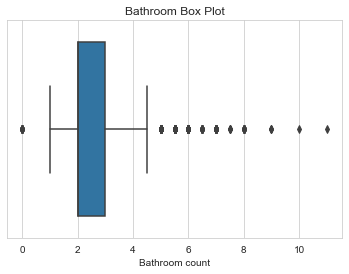

In [18]:
# Bathroomcnt box plots

sns.boxplot(df.bathroomcnt)
plt.xlabel('Bathroom count')
plt.title('Bathroom Box Plot')
plt.show()


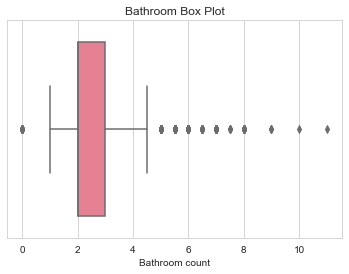

In [19]:
# Bathroomcnt box plots

sns.boxplot(df.bathroomcnt, palette = 'husl')
plt.xlabel('Bathroom count')
plt.title('Bathroom Box Plot')
plt.show()


There are outliers in properties that have more than 4 bathrooms

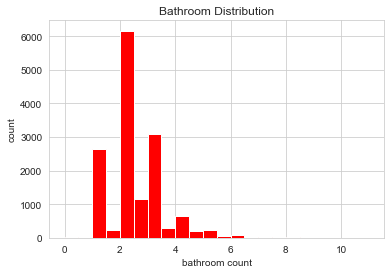

In [20]:
# bathroom count distribution, because bathrooms are a discrete variable we will plot the distribution using a histogram

plt.hist(df.bathroomcnt, bins = [x*.5 for x in range(0,23)], color = 'red')
plt.xlabel('bathroom count')
plt.ylabel('count')
plt.title('Bathroom Distribution')
plt.show()


In [21]:
df.bathroomcnt.value_counts().sort_index()


0.0       16
1.0     2634
1.5      237
2.0     6165
2.5     1155
3.0     3088
3.5      302
4.0      651
4.5      217
5.0      224
5.5       65
6.0       95
6.5       15
7.0       25
7.5        4
8.0       14
9.0        3
10.0       1
11.0       1
Name: bathroomcnt, dtype: int64

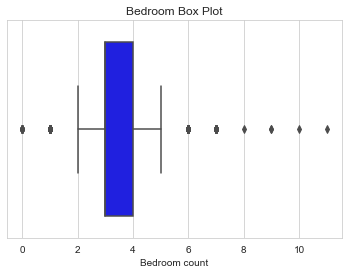

In [22]:
# Bedroomcnt box plots

sns.boxplot(df.bedroomcnt, color = 'blue')
plt.xlabel('Bedroom count')
plt.title('Bedroom Box Plot')
plt.show()


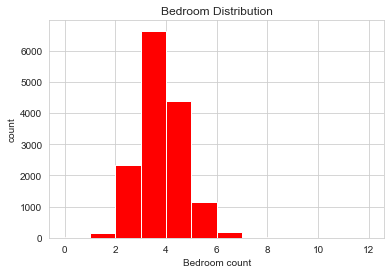

In [23]:
# bedroom count distribution, because bedrooms are a discrete variables we will plot the distibution using a histogram.

plt.hist(df.bedroomcnt, bins = [x for x in range(0,13)], color = 'red')
plt.xlabel('Bedroom count')
plt.ylabel('count')
plt.title('Bedroom Distribution')
plt.show()


We see outliers as well for bedrooms with less than 2 and more than 5

For bedroom and bathroom counts most of the values lie between 1 and 6.


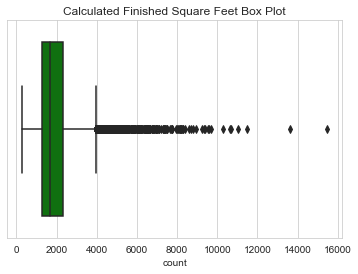

In [24]:
#Calculatedfinished squarefeet box plots

sns.boxplot(df.calculatedfinishedsquarefeet, color = 'green')
plt.xlabel('count')
plt.title('Calculated Finished Square Feet Box Plot')
plt.show()


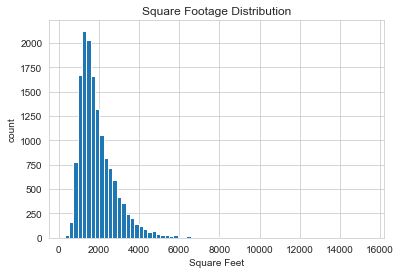

In [25]:
# calculatedfinishedsquarefeet is also a discrete variable.

plt.hist(df.calculatedfinishedsquarefeet, bins = 70)
plt.xlabel('Square Feet')
plt.ylabel('count')
plt.title('Square Footage Distribution')
plt.show()


In [26]:
df.bedroomcnt.value_counts().sort_index()


0.0       15
1.0      170
2.0     2328
3.0     6644
4.0     4392
5.0     1148
6.0      183
7.0       27
8.0        1
9.0        2
10.0       1
11.0       1
Name: bedroomcnt, dtype: int64

In [27]:
df.calculatedfinishedsquarefeet.value_counts(bins = 70).sort_index()


(284.84900000000005, 516.429]      24
(516.429, 732.857]                163
(732.857, 949.286]                778
(949.286, 1165.714]              1671
(1165.714, 1382.143]             2126
(1382.143, 1598.571]             2029
(1598.571, 1815.0]               1660
(1815.0, 2031.429]               1317
(2031.429, 2247.857]             1051
(2247.857, 2464.286]              821
(2464.286, 2680.714]              721
(2680.714, 2897.143]              597
(2897.143, 3113.571]              419
(3113.571, 3330.0]                356
(3330.0, 3546.429]                243
(3546.429, 3762.857]              206
(3762.857, 3979.286]              139
(3979.286, 4195.714]              125
(4195.714, 4412.143]               95
(4412.143, 4628.571]               64
(4628.571, 4845.0]                 66
(4845.0, 5061.429]                 36
(5061.429, 5277.857]               27
(5277.857, 5494.286]               28
(5494.286, 5710.714]               18
(5710.714, 5927.143]               24
(5927.143, 6

Text(0.5, 1.0, 'Lot Size Distribution')

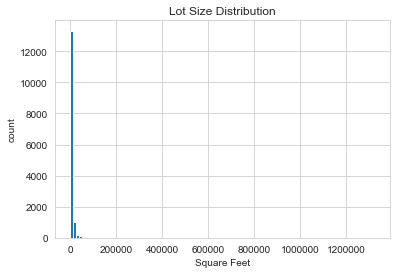

In [28]:
# lotsizesquarefeet is a discrete variables. We will split the data into bins to view where most of the properties are at.

df.lotsizesquarefeet.value_counts(bins = 100).sort_index().idxmax()
plt.hist(df.lotsizesquarefeet, bins = 100)
plt.xlabel('Square Feet')
plt.ylabel('count')
plt.title('Lot Size Distribution')


Text(0.5, 1.0, 'Lot Size Distribution')

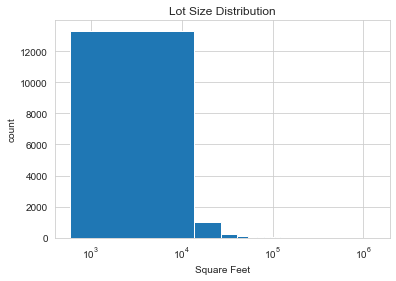

In [29]:
plt.hist(df.lotsizesquarefeet, bins = 100)
plt.xlabel('Square Feet')
plt.xscale('log')
plt.ylabel('count')
plt.title('Lot Size Distribution')


Data Dictionary:

Independent Variables:

bathroomcnt: Count of total number of bathrooms on the property. Did not choose to use calculatedbathnbr because this only took into account bathrooms attached to bedrooms.

bedroomcnt: Count of total number of bedrooms on the property. Did not choose to use calculatedbathnbr because this only took into account bathrooms attached to bedrooms.

calculatedfinishedsquarefeet: Total amount of squarefootage of the property. This does not include lot size. There were other finishedsquare feet columns 12, 13, 50, 15, 6. These other finished square feet columns contained significant amounts of NULL values that would have effected how many data samples we had. Not that having more data is better, we just had another columns with finishedsquarefeet that could represent the living squarefootage of the property.

lotsizesquarefeet: Total amount of square feet of the lot. This will be a good value to use because we are looking at property square footage as well that is only the amount of living squarefeet. The lotsize can tell us about the value of the property as well.

Target Variable:
taxvaluedollarcount: This data calculated both the structuretaxvaluedollarcnt and landtaxvaluedollarcnt. Taxvaluedollarcnt was the similar way to predict how much someone might pay for a property.

Index:
parcelid: to keep some of the integrity of the data we will use the parcelid number of the properties as index values. This will help in future research of looking at characteristics of specific properties, and how they influence their property value.

fips: assigned county of the property
    fips locations:
        6037 - California - Los Angeles County
        6059 - California - Orange County
        6111 - California - Venture County

Scaling our data:

Our independent variables, and target variables are measured in two different ways:
    1. Square footage - calculatedfinishedsquarefeet, lotsizesquarefeet
    2. Quanity Count - bedroomcnt, bathroomcnt
    3. Cost - taxvaluedollarcnt

There are some outliers in our data where they have a high bedroom, bathroom, or calculated squarefootage. Because of these values we will use a Robust Scaler. The centering and scaling of the Robust scaler are based on percentiles. This means that the scaling is not influenced by a few number of very large marginal outliers. 
<https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html>

Erroneous or Invalid Data:
There was not outstanding erroneous data found in the preperation. We are going to keep properties that have bedrooms, or bathrooms as 0 because they still have a calculatedfinsihedsquarefeet. The squarefootage will drive the values of the property more than the room count. 
The values that were droped from the dataframe are the null values in calculated finished square feet.


In [30]:
# use split_scale.py function split_my_data(df) to create train and test dateframes

train, test = split_scale.split_my_data(df)


In [31]:
# use split_scale.py function iqr_robust_scaler(train,test) to scale the data so they will be on the same unit scale. We do this because in the prep phase we saw that some variables are measured in squarefeet, and rooms are just a count value.

scaler, train_scaled, test_scaled = split_scale.iqr_robust_scaler(train, test)


In [32]:
# Look at our scaled data

train_scaled.head()


,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,taxvaluedollarcnt
"(11461315, 6037.0)",1.0,1.0,0.146226,-0.115479,1.116738
"(11149006, 6037.0)",2.0,2.0,1.510377,3.459459,0.685457
"(14436340, 6059.0)",1.0,1.0,-0.182075,32.671376,0.131194
"(11203873, 6037.0)",0.0,0.0,-0.326415,-0.211609,-0.590122
"(13007611, 6037.0)",3.0,1.0,1.365094,0.785627,1.388001


In [33]:
test_scaled.head()


,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,taxvaluedollarcnt
"(12471371, 6037.0)",-1.0,0.0,-0.494340,-0.323710,-0.716343
"(14350990, 6059.0)",0.5,0.0,0.755660,-1.301597,0.086451
"(10994984, 6037.0)",-1.0,0.0,-0.504717,-0.665233,-0.421972
"(11152526, 6037.0)",1.0,2.0,0.142453,0.062961,-0.182887
"(14163099, 6059.0)",1.5,1.0,2.157547,1.284091,1.402376


In [34]:
# X_train_scaled dataframe will be our indepenent variables : bathroomcnt, bedroomcnt,  caluclatedfinishedsquarefeet, lotsizesquarefeet.
# y_train_scaled dataframe will be out target variable: taxvaluedollarcnt

X_train_scaled = train_scaled[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet']]
y_train_scaled = train_scaled[['taxvaluedollarcnt']]


In [35]:
# X_test_scaled dataframe will be 20% of our dataframe and reflect the variables in our training datasets.

X_test_scaled = test_scaled[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet']]
y_test_scaled = test_scaled[['taxvaluedollarcnt']]


***Data Exploration***

Goal: Address questions posed in the planning brainstorming phase, and any other questions that have come up along the way through visual or statiscal analysis


*** Recap from hypothesis above: ***

Which independent variables do you think influence the value of a home?

Hypothesis:

Variables that can influence the value of home are square feet,  and room count(bedroom, and bath). 
These two variables can have an influence no matter where the property located.

The more square feet of a property the more the value of the home will rise.
The higher the room count the cost will increase.
The total square footage of the property will be a stronger influence than room count

When you start to get into specific locations other factors can influence the value of a home such as zip code, school district, distance to destinations (work, home, restaurants, grocery).
Also home amenities will influence the value of a property, such as backyards with pools, garage size, hoa.
The age of home would also have influence.

In [36]:
# look at the correlation values between independent variables, and grab the correlation column that compares the variables to our target taxvaluedollarcnt.

train_scaled.corr()
train_scaled.corr().taxvaluedollarcnt


bathroomcnt                     0.516131
bedroomcnt                      0.277473
calculatedfinishedsquarefeet    0.605381
lotsizesquarefeet               0.110503
taxvaluedollarcnt               1.000000
Name: taxvaluedollarcnt, dtype: float64

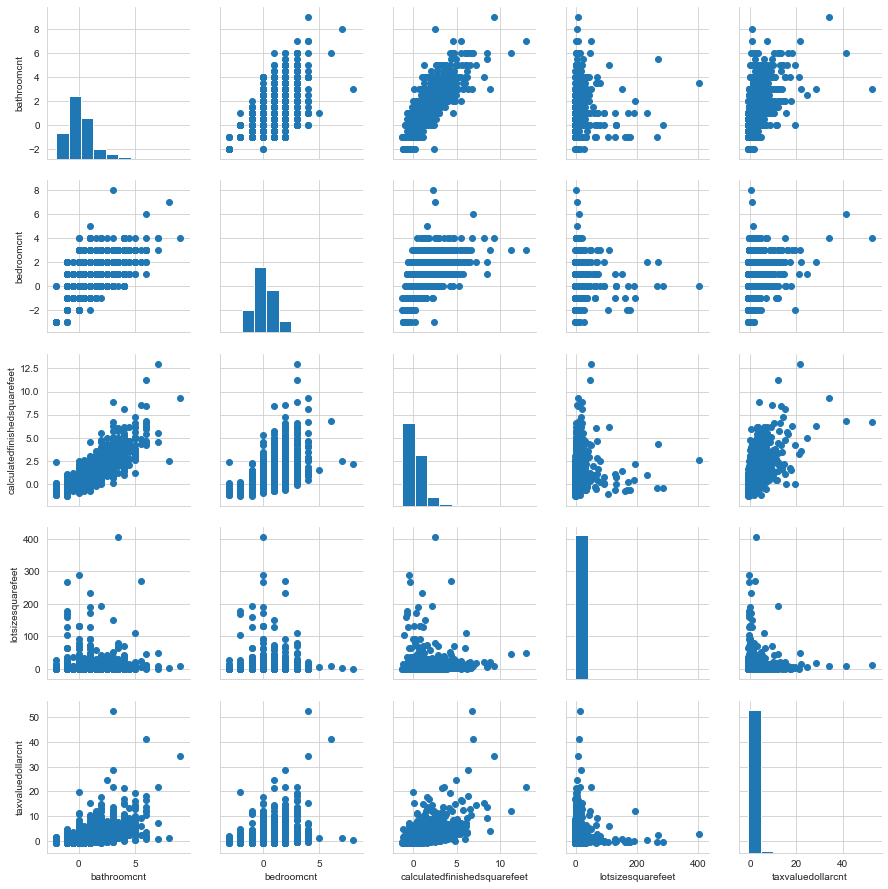

In [37]:
# Look at the correlation of a variables with sns.PairGrid

g = sns.PairGrid(train_scaled, palette = 'reds')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);


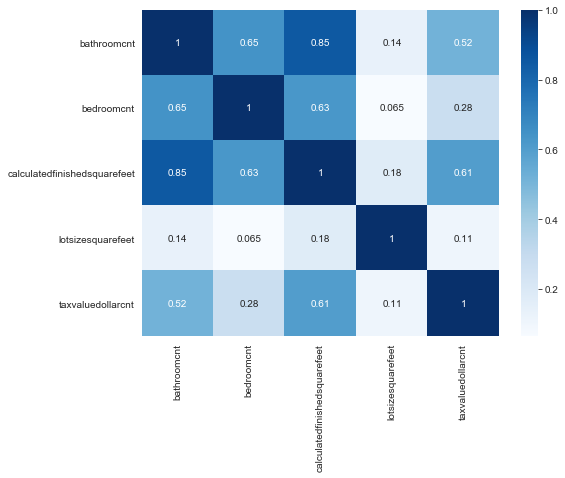

In [38]:
# Look at the correlation of variables with sns.heatmap 

plt.figure(figsize = (8,6))
sns.heatmap(train.corr(), cmap = 'Blues', annot = True )


 T test - Is the average taxvaluedollarcnt different for one bedroom vs. three bedrooms?
 
 H[0]: The average taxvaluedollarcount of properties with one bedroom or three bedrooms is the same


In [39]:
# We'll need to create two seperate datasets that contain the values for taxvaluedollarcnt for properties with one bedroom and properties with two bedrooms

bedrooms_1 = train_scaled[train_scaled['bedroomcnt'] == 1]
bedrooms_3 = train_scaled[train_scaled['bedroomcnt'] == 3]
test_results = ttest_ind(bedrooms_1.taxvaluedollarcnt, bedrooms_3.taxvaluedollarcnt)


In [40]:
# Because the p value is so small, we reject the null hypothesis. We think there is a significant difference in the average taxvaluedollarcnt of properties with 1 bedroom and properties with 3 bedrooms.
# Let's look at those averages:

bedrooms_1.taxvaluedollarcnt.mean()
bedrooms_3.taxvaluedollarcnt.mean()


2.475501727520048

T Test - Is the average taxvaluedollarncnt different for one bathroom vs. three bathroom properties?

H[0]: The average taxvaluedollarcnt of properties with one bathroom or three bathrooms is the same.

In [41]:
bathrooms_1 = train_scaled[train_scaled['bathroomcnt'] == 1]
bathrooms_3 = train_scaled[train_scaled['bathroomcnt'] == 3]
test_results = ttest_ind(bathrooms_1.taxvaluedollarcnt, bathrooms_3.taxvaluedollarcnt)


In [42]:
# Because the p value is so small, we reject the null hypothesis. We think there is a significant difference in the average taxvaluedollarcnt of properties with 1 bathroom and properties with 3 bedrooms.
# Let's look at those averages:

bathrooms_1.taxvaluedollarcnt.mean()
bathrooms_3.taxvaluedollarcnt.mean()


3.378091415420285


Pearson R - Are bathrooms and bedrooms linearly correlated, and what is the strength of that correlation?
H[0]: There is not a linear correlation between number of bathrooms and number of bedrooms for a property.


In [43]:
# We can pass the two series that contain the values we are looking at to the pearsonr function from scipy's stats module.

test_results_pearsonr = pearsonr(train_scaled.bathroomcnt, train_scaled.bedroomcnt)


Because pearsonr is 0.0 we reject the null hypothesis that there is no linear relationship. The test also tells us the r^2 value of .645

Pearson R - Are bathrooms and calculatedfinished square feet linearly correlated, and what is the strength of that correlation?

H[0]: There is not a linear correlation between number of bathrooms and calculatedfinished sqaure feet for a property.

In [44]:
# We can pass the two series that contain the values we are looking at to the pearsonr function from scipy's stats module.

test_results_pearsonr = pearsonr(train_scaled.bathroomcnt, train_scaled.calculatedfinishedsquarefeet)


because pearsonr is 0.0 we reject the null hypothesis that there is no linear relationship. The test also tells us the r ^2 value of .852 that this the strength of the relationship.



Take aways from exploration:
Calculated finished square feet is the most correlated to our dependent (target variable) taxvaluedollarcnt. From our hypothesis that our presumption that calculated finished square feet will influence taxvalue dollar count in a positive direction (overall taxvaluedollarcnt increases when calculated finished squarefeet increases)

We see that calculated finished square feet correlates with both bedroom, and bathroom count. This makes sense because the amount of liveable square fee will drive the amount of bedrooms, and bathrooms on a property. This finding is going to influence the feature selection. It gives the direction that you could combine bedroom, and bathroom count into one feature. Then use this combined room count feature in the selection process. 

Don't like that independent variables are correlated with each other so in feature selection process and modeling would want to see which of those give us better prediction values.

*** Feature Selection ***

Goal: Create a dataframe(s) with the features to be used to build your model.

In [45]:
# Perform feature selection using RFE. Use features.py file function optimal_number_of_features to perform recursive feature elimination that will tell us the number of features to use to predict our target variable

number_of_features, score = features.optimal_number_of_features(X_train_scaled, y_train_scaled)
number_of_features, score


(4, 0.38561254725371386)

In [46]:
# Use recursive feature elimination. Use features.py file function optimal features to find out which features should be used

selected_features_rfe, X_train_rfe, X_test_rfe = features.optimal_features(X_train_scaled, X_test_scaled, y_train_scaled, number_of_features)
selected_features_rfe


Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'lotsizesquarefeet'],
      dtype='object')

*** Modeling & Evaluation ***
Goal: develop a regression model that performs better than using overall average taxvaluedollarcnt as a baseline.

In [47]:
# Create prediction dataframes for train and test data. Use model.py function modeling_function to create linear model_1, and compare to baseline prediction of mean taxvaluedollarcnt.
predictions_train, predictions_test = model.modeling_function(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)


In [48]:
predictions_train.head()


,actual,lm1,baseline
0,1.116738,0.091649,0.346554
1,0.685457,1.430190,0.346554
2,0.131194,-0.302283,0.346554
3,-0.590122,-0.239296,0.346554
4,1.388001,1.701819,0.346554


In [49]:
predictions_test.head()


,actual,lm2,baseline
0,-0.716343,-0.674608,0.351353
1,0.086451,1.071122,0.351353
2,-0.421972,-0.686982,0.351353
3,-0.182887,-0.285228,0.351353
4,1.402376,2.504842,0.351353


Create residual plots for independent variables vs. target variable lotsizesquarefeet

In [50]:
x1 = X_train_scaled[['calculatedfinishedsquarefeet']]
x2 = X_train_scaled[['bedroomcnt']]
x3 = X_train_scaled[['bathroomcnt']]
x4 = X_train_scaled[['lotsizesquarefeet']]

In [51]:
y = y_train_scaled[['taxvaluedollarcnt']]


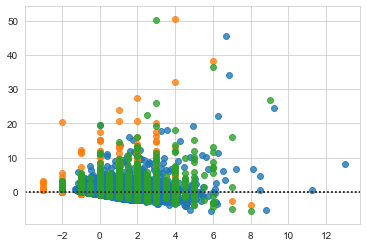

In [52]:
model.plot_residuals(x1,y)
model.plot_residuals(x2,y)
model.plot_residuals(x3,y)
#model.plot_residuals(x4,y)
#plt.xscale('log')
#plt.xlim(-100,400)

Plot residual of baseline - predicted value is the average taxvaluedollarcnt.

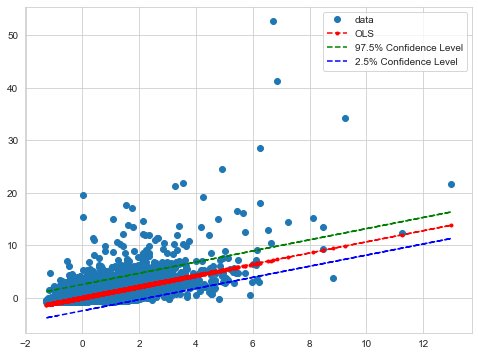

In [53]:
model.plot_regression(x1,y)

OLS Summary

In [54]:
X = X_train_scaled
y = y_train_scaled

In [55]:
X = sm.add_constant(X)

In [56]:
est = sm.OLS(y,X).fit()

In [57]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      taxvaluedollarcnt   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     1871.
Date:                Mon, 21 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:43:02   Log-Likelihood:                -19664.
No. Observations:               11929   AIC:                         3.934e+04
Df Residuals:                   11924   BIC:                         3.937e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.1303      0.012     10.595      0.000       0.106       0.154
bathroomcnt                      0.1150      0.022      5.112      0.000       0.071       0.159
bedroomcnt                      -0.3194      0.017    -19.259      0.000      -0.352      -0.287
calculatedfinishedsquarefeet     1.1328      0.024     46.700      0.000       1.085       1.180
lotsizesquarefeet               -0.0007      0.001     -0.520      0.603      -0.003       0.002
==============================================================================
Omnibus:                    19069.897   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         30220453.163
Skew:                          10.022   Prob(JB):                         0.00
Kurtosis:                     248.762   Cond. No.                         24.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Conclusion:

From the ols model our baseline of average property value did worse than our prediction model using features of bedroomcnt, bathroomcnt, calculatedfinished square feet, and lotsize. We can make this conclusion because our R^2 value is .38, and our values p-values for a a variables are significant. We can reject the null hypothesis that a model of average values will be the same as model without our features.

Going forward in this project I would suggest to look at property locations, you can begin to do this by grouping by the fips values of properties